# M E T R O

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import ogr
import networkx as nx
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import random as ran
import json
import lineas
import folium
import mplleaflet

Creamos una gráfica vacía y cargamos un json el cual contiene las coordenadas de cada una de las estaciones.

In [74]:
estaciones=nx.Graph()                      # Creamos una gráfica 
aristas = json.loads(lineas.jason)  

In [75]:
tamaño = [len(aristas[key]['coordinates'])for key in aristas]
print(tamaño)
print(sum(tamaño))

[13, 10, 20, 11, 21, 20, 14, 21, 19, 24, 10, 12]
195


Para medir la distancia entre dos puntos, utilizamos la función geocalc, la cual regresa la distancia, en kilometros, de dos puntos dados en coordenadas geográficas.
La distancia se mide para así poder darle ese peso a las aristas de la gráfica.

In [76]:
# Función para medir la distancia entre dos puntos.
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [77]:
# Se conectan los nodos de las estaciones creando así las aristas.
distancias = []

for key in aristas:
    i = 0
    ar = aristas[key]['coordinates']
    while i < len(ar)-1:
        x = (ar[i][1],ar[i][2])
        y = (ar[i+1][1],ar[i+1][2])
        estaciones.add_edge(x,y)
        distancias.append([x,y,geocalc(x[1], x[0], y[1], y[0])])
        i+=1

estaciones_list= list(estaciones)


In [78]:
len(estaciones.nodes)

163

In [79]:
labels = {}
for key in aristas:
    i = 0
    ar = aristas[key]['coordinates']
    while i < len(ar):
        x = (ar[i][1],ar[i][2])
        labels[x] = ar[i][0]
        i+=1

In [60]:
# Se agregan los pesos (distancia) a cada arista dependiendo de los puntos anteriores.
for v,w in estaciones.edges:
   estaciones.edges[v,w]["weight"] = geocalc(v[1], v[0], w[1],w[0])
    

In [61]:
# Prueba para si las distancias son iguales.
#estaciones.get_edge_data((-99.1555542, 19.4903266), (-99.1449058, 19.4896945))

In [62]:
#Vemos si la gráfica es densa.
nx.density(estaciones)

0.01386048625312429

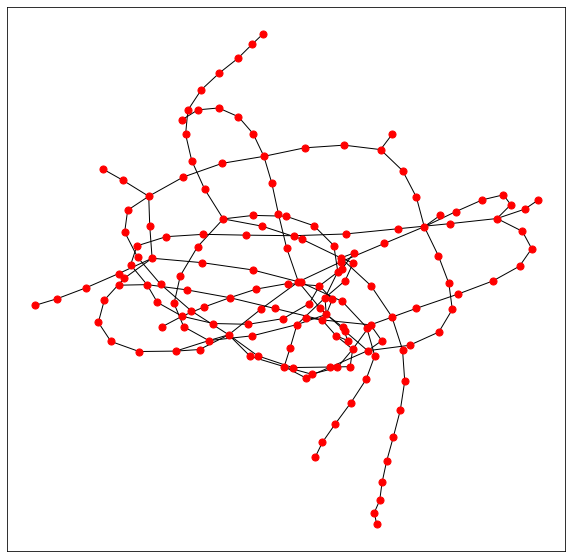

In [72]:
#Ploteamos la gráfica.
plt.figure(figsize=(10,10))
nx.draw_networkx(estaciones, with_labels = False,
                node_size = 50, node_color = 'red')

Tomamos dos estaciones de metro, lomas estrella (n0) e insurgentes (n1) y calculamos las rutas más cortas y **la ruta más corta** por el algoritmo de Dijkstra con y sin peso y Bellman Ford.

In [85]:
#n1 = (-99.0976121386369,19.3223865035373) #lomas estrella
#n2 = (-99.1627908,19.4236259) # insurgentes



In [86]:
shortest_paths=[p for p in nx.all_shortest_paths(estaciones, n1,n2, weight = True)]

print("Se tienen {} rutas más cortas para ir de __ a __".format(len(shortest_paths)))  
      

Se tienen 4 rutas más cortas para ir de __ a __


In [87]:
path = nx.shortest_path(estaciones,n1,n2) # Sin medir la distancia
path2 = nx.shortest_path(estaciones,n1,n2, weight = True) # Midiendo la distancia
djs_path = nx.dijkstra_path(estaciones,n1,n2) # Con Dijkstra y distancias
bell_path = nx.bellman_ford_path(estaciones,n1,n2) # Con Bellman Ford y distancias


La ruta más corta es: [(-99.0976121386369, 19.3223865035373), (-99.1050339189064, 19.3276021253425), (-99.10888888888888, 19.3369444), (-99.1013199, 19.3561791), (-99.12166666666666, 19.3577778), (-99.1429317, 19.3619032), (-99.1540513377261, 19.3617505941329), (-99.1567512289475, 19.3705634323458), (-99.1649204, 19.3707294), (-99.1591108, 19.3798486), (-99.1574532, 19.3855061), (-99.1562569, 19.3956264), (-99.1552055, 19.4066618), (-99.1538858, 19.4135984), (-99.1505706, 19.4195583), (-99.149074, 19.42741), (-99.154653, 19.425867), (-99.1627908, 19.4236259)]
True
18
18


In [90]:
# lambda para cambiar el path al nombre de las estaciones.
translate_path= lambda path: [labels[tup] for tup in path]
translate(path)

print("La ruta más corta es: " + str(bell_path)) 
print(bell_path == djs_path)
print(len(djs_path))
print(len(path))

['Lomas Estrella',
 'San Andrés Tomatlán MAL',
 'Culhuacan',
 'Atlalilco',
 'Mexicaltzingo',
 'Ermita',
 'Portales',
 'Nativitas',
 'Villa de Cortés',
 'Xola',
 'Viaducto',
 'Chabacano',
 'Obrera',
 'Doctores',
 'Salto del Agua',
 'Balderas',
 'Cuahtémoc',
 'Insurgentes']

### Ploteamos las rutas más cortas.

In [16]:
lat =[]
lon = []
for i in range(len(shortest_paths[0])):
    lon.append(shortest_paths[0][i][0])
    lat.append(shortest_paths[0][i][1])
    
plt.plot(lon,lat, 'r') 
plt.plot(lon,lat, 'rs')
mplleaflet.display()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Ploteamos la ruta más corta

In [17]:
lat =[]
lon = []
for i in range(len(path)):
    lon.append(path[i][0])
    lat.append(path[i][1])
    
plt.plot(lon,lat, 'r') 
plt.plot(lon,lat, 'rs')
mplleaflet.display()

In [18]:
dist_corta = nx.shortest_path_length(estaciones, n1,n2)
print('La ruta más corta de ___ a____ es de {} km'.format(dist_corta))

La ruta más corta de ___ a____ es de 10 km


### Ploteamos la ruta más corta (Dijkstra)

In [19]:
lat =[]
lon = []
for i in range(len(djs_path)):
    lon.append(djs_path[i][0])
    lat.append(djs_path[i][1])
    
plt.plot(lon,lat, 'r') 
plt.plot(lon,lat, 'rs')
mplleaflet.display()

In [20]:
dist_corta = nx.dijkstra_path_length(estaciones, n1,n2, weight = True)
print('La ruta más corta de ___ a____ es de {} km'.format(dist_corta))

La ruta más corta de ___ a____ es de 10 km


### Ploteamos la ruta más corta (Bellman Ford)

In [21]:
lat =[]
lon = []
for i in range(len(bell_path)):
    lon.append(bell_path[i][0])
    lat.append(bell_path[i][1])
    
plt.plot(lon,lat, 'r') 
plt.plot(lon,lat, 'rs')
mplleaflet.display()

In [22]:
mapa = folium.Map(location=[19.4284700,-99.1276600])  # inicilizamos con las coordenadas de la ciudad de mexico
for i in range(len(path)):
    folium.CircleMarker([path[i][1], path[i][0]], fill = True,
                       radius = 3, color = 'red', fill_opacity = 1).add_to(mapa)
    #folium.PolyLine(path, color="green", weight=2.5, opacity=1).add_to(my_map)
mapa
#mapa.save(('plot_data.html'))